In [21]:
import phoebe
import numpy as np
from spice.models.phoebe_model import PhoebeModel
from spice.spectrum import simulate_spectrum
from transformer_payne import Blackbody

In [22]:
import astropy.units as u
u.solRad.to(u.cm)

69570000000.0

In [23]:
4*np.pi*69570000000.0**2

6.082104402130212e+22

In [24]:
import matplotlib
%matplotlib inline

In [25]:
from phoebe.parameters.dataset import _mesh_columns

In [26]:
b = phoebe.default_star()
b.set_quantity('incl', 5)
times = np.linspace(0, 24*3600, 10)
COLUMNS = _mesh_columns
b.add_dataset('mesh', times=times, columns=COLUMNS, dataset='mesh01')
b.run_compute(irrad_method='none', coordinates='uvw')

100%|██████████| 10/10 [00:00<00:00, 175.00it/s]


<ParameterSet: 312 parameters | qualifiers: rprojs, areas, vus, mus, vys, visible_centroids, us, volume, nus, teffs, rs, loggs, comments, ws, times, uvw_elements, zs, nvs, nzs, vxs, vws, vvs, nxs, xs, nys, uvw_normals, vzs, visibilities, xyz_normals, ys, xyz_elements, vs, nws>

In [27]:
b.get_parameter(time=0, qualifier='mus').description

'Mu'

In [28]:
[p.qualifier for p in b.__dict__['_params'] if 'faces' in p.qualifier]

[]

In [29]:
b.get_parameter(time=0., qualifier='uvw_elements').value.shape

(1710, 3, 3)

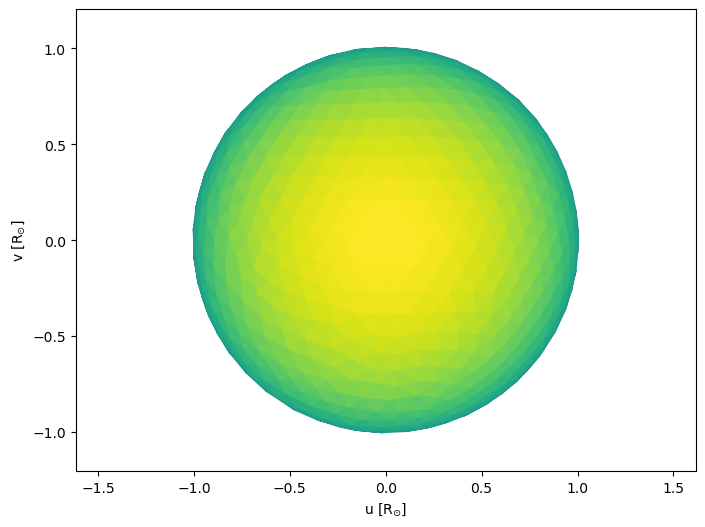

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [30]:
b.plot(dataset='mesh01', time=0.0, fc='mus', ec='face', show=True, colorbar=True)

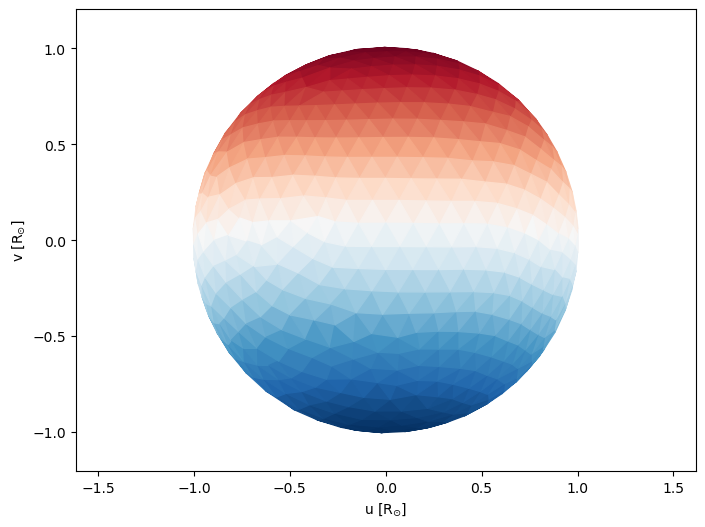

(<autofig.figure.Figure | 1 axes | 1 call(s)>,
 <Figure size 800x600 with 1 Axes>)

In [31]:
b.plot(dataset='mesh01', time=0.0, fc='vus', ec='face', show=True, colorbar=True)

In [32]:
from spice.models.phoebe_utils import PhoebeConfig
p = PhoebeConfig(b, 'mesh01')

In [33]:
b = Blackbody()
pm = PhoebeModel.construct(p, times[4], b.parameter_names)

In [34]:
np.where(pm.mus>0, pm.mus, 0.)

array([0.98954124, 0.98605655, 0.98953066, ..., 0.        , 0.        ,
       0.        ])

In [35]:
pm.cast_areas

array([ 5.04630332e+20,  5.02841868e+20,  5.04595752e+20, ...,
       -2.57863412e+20, -2.73952182e+20, -4.68024435e+20])

In [36]:
ws = np.linspace(4000, 10000, 1000)
s = simulate_spectrum(b.intensity, pm, np.log10(ws))

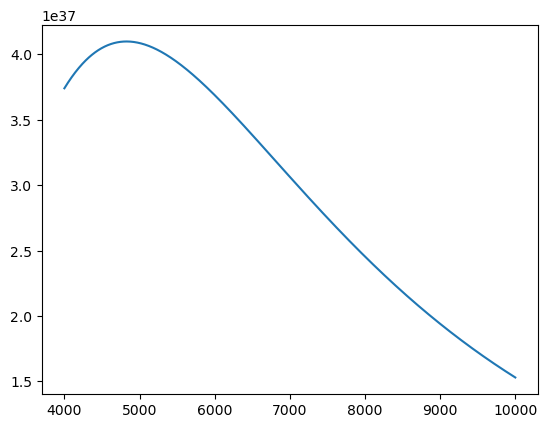

In [37]:
import matplotlib.pyplot as plt
plt.plot(ws, s[:, 0])

In [38]:
from spice.plots import plot_3D
import matplotlib as mpl
from mpl_toolkits.mplot3d import art3d

Is the rotation axis and LOS vector reversed actually?

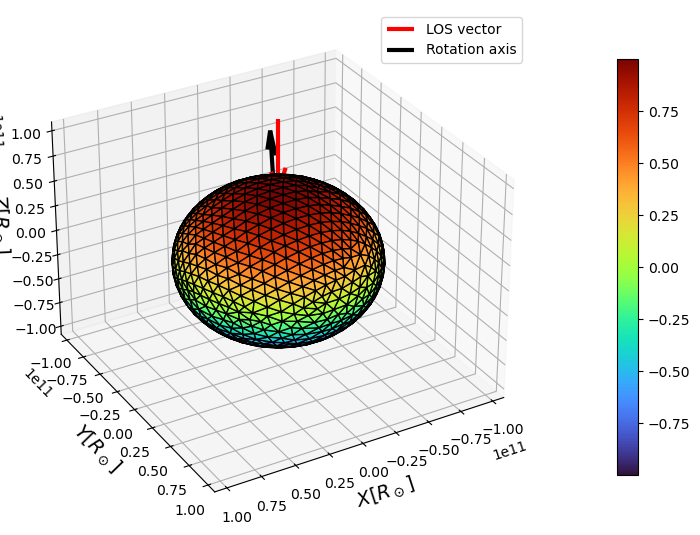

In [39]:
fig = plt.figure(figsize=(10, 12))
spec = fig.add_gridspec(10, 12)
plot_ax = fig.add_subplot(spec[:, :11], projection='3d')
plot_ax.view_init(elev=30, azim=60)
axes_lim = 1.5*pm.radius
plot_ax.set_xlim3d(-axes_lim, axes_lim)
plot_ax.set_ylim3d(-axes_lim, axes_lim)
plot_ax.set_zlim3d(-axes_lim, axes_lim)
plot_ax.set_xlabel('$X [R_\\odot]$', fontsize=14)
plot_ax.set_ylabel('$Y [R_\\odot]$', fontsize=14)
plot_ax.set_zlabel('$Z [R_\\odot]$', fontsize=14)
normalized_los_vector = pm.los_vector/np.linalg.norm(pm.los_vector)
normalized_rotation_axis = pm.rotation_axis/np.linalg.norm(pm.rotation_axis)
mesh=pm
plot_ax.quiver(*(-2.0*mesh.radius*normalized_los_vector), *(mesh.radius*normalized_los_vector),
                   color='red', linewidth=3., label='LOS vector')
plot_ax.quiver(*(0.75*mesh.radius*normalized_rotation_axis), *(mesh.radius*normalized_rotation_axis),
                color='black', linewidth=3., label='Rotation axis')
plot_ax.legend()
vs2 = mesh.cast_vertices
to_be_mapped = pm.mus
norm = mpl.colors.Normalize(vmin=to_be_mapped.min(), vmax=to_be_mapped.max())
mappable = mpl.cm.ScalarMappable(cmap='turbo', norm=norm)
face_colors = mpl.colormaps['turbo'](norm(to_be_mapped))
p = art3d.Poly3DCollection(vs2, facecolors=face_colors, edgecolor="black")
plot_ax.add_collection(p)
mappable.set_array([])
cbar = fig.colorbar(mappable, shrink=0.45, pad=0.125, ax=plot_ax)

In [43]:
fig = plt.figure(figsize=(10, 12))
spec = fig.add_gridspec(10, 12)
plot_ax = fig.add_subplot(spec[:, :11], projection='3d')
plot_ax.view_init(elev=30, azim=60)
axes_lim = 1.5*pm.radius
plot_ax.set_xlim3d(-axes_lim, axes_lim)
plot_ax.set_ylim3d(-axes_lim, axes_lim)
plot_ax.set_zlim3d(-axes_lim, axes_lim)
plot_ax.set_xlabel('$X [R_\\odot]$', fontsize=14)
plot_ax.set_ylabel('$Y [R_\\odot]$', fontsize=14)
plot_ax.set_zlabel('$Z [R_\\odot]$', fontsize=14)
normalized_los_vector = pm.los_vector/np.linalg.norm(pm.los_vector)
normalized_rotation_axis = pm.rotation_axis/np.linalg.norm(pm.rotation_axis)
mesh=pm
plot_ax.quiver(*(-2.0*mesh.radius*normalized_los_vector), *(mesh.radius*normalized_los_vector),
                   color='red', linewidth=3., label='LOS vector')
plot_ax.quiver(*(0.75*mesh.radius*normalized_rotation_axis), *(mesh.radius*normalized_rotation_axis),
                color='black', linewidth=3., label='Rotation axis')
plot_ax.legend()
vs2 = mesh.cast_vertices
to_be_mapped = pm.mus
norm = mpl.colors.Normalize(vmin=to_be_mapped.min(), vmax=to_be_mapped.max())
mappable = mpl.cm.ScalarMappable(cmap='turbo', norm=norm)
face_colors = mpl.colormaps['turbo'](norm(to_be_mapped))
c = pm.centers
v = pm.center_velocities
for cc, vv in zip(c, v):
    plot_ax.quiver(*(cc), *(0.04*mesh.radius*vv), alpha=0.3)
p = art3d.Poly3DCollection(vs2, facecolors=face_colors, edgecolor="black")
plot_ax.add_collection(p)
mappable.set_array([])
cbar = fig.colorbar(mappable, shrink=0.45, pad=0.125, ax=plot_ax)